# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`:*Sai Chinmayi Kalapatapu*  
**`Roll Number`:*U20230085*  
**`GitHub Branch`:** chinmayi_U20230085  

In [121]:
ROLL_NUMBER = 85
T = 10_000
RUNS = 20

In [122]:
pip install numpy pandas matplotlib scikit-learn rlcmab-sampler

# Imports and Setup

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from rlcmab_sampler import sampler

#Load The Datasets

In [124]:
# Load datasets
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

print(news_df.head())
print(train_users.head())

                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog y

In [153]:
train_users.shape

(2000, 33)

## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [125]:
print("Missing values in train_users:")
print(train_users.isnull().sum())

print("Missing values in test_users:")
print(test_users.isnull().sum())

print("Dtypes in train_users:")
print(train_users.dtypes)

print("Unique labels in train_users:")
print(train_users['label'].unique())
print(f"Label distribution:\n{train_users['label'].value_counts()}")

print("Summary statistics for train_users:")
print(train_users.describe())

Missing values in train_users:
user_id                          0
age                            698
income                           0
clicks                           0
purchase_amount                  0
session_duration                 0
content_variety                  0
engagement_score                 0
num_transactions                 0
avg_monthly_spend                0
avg_cart_value                   0
browsing_depth                   0
revisit_rate                     0
scroll_activity                  0
time_on_site                     0
interaction_count                0
preferred_price_range            0
discount_usage_rate              0
wishlist_size                    0
product_views                    0
repeat_purchase_gap (days)       0
churn_risk_score                 0
loyalty_index                    0
screen_brightness                0
battery_percentage               0
cart_abandonment_count           0
browser_version                  0
background_app_count    

In [126]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Drop user_id column
train_users_proc = train_users.drop(columns=['user_id'])
test_users_proc = test_users.drop(columns=['user_id'])

# Separate features and labels for training data
X = train_users_proc.drop(columns=['label'])
y = train_users_proc['label']

print("="*70)
print("INITIAL DATA ANALYSIS")
print("="*70)
print(f"\nTraining data shape: {X.shape}")
print(f"Test data shape: {test_users_proc.shape}")

print("\nMissing values in training data:")
missing_train = X.isnull().sum()
print(missing_train[missing_train > 0])

print("\nMissing values in test data:")
missing_test = test_users_proc.isnull().sum()
print(missing_test[missing_test > 0])


# HANDLE NUMERICAL COLUMNS WITH MISSING VALUES


age_imputer = SimpleImputer(strategy='median')
X['age'] = age_imputer.fit_transform(X[['age']])
test_users_proc['age'] = age_imputer.transform(test_users_proc[['age']])

if X['income'].isnull().sum() > 0:
    income_imputer = SimpleImputer(strategy='median')
    X['income'] = income_imputer.fit_transform(X[['income']])
    test_users_proc['income'] = income_imputer.transform(test_users_proc[['income']])

numerical_cols_to_impute = [
    'clicks', 'purchase_amount', 'session_duration', 'content_variety',
    'engagement_score', 'num_transactions', 'avg_monthly_spend',
    'avg_cart_value', 'loyalty_index', 'screen_brightness',
    'battery_percentage', 'cart_abandonment_count',
    'background_app_count', 'session_inactivity_duration', 'network_jitter'
]

for col in numerical_cols_to_impute:
    if col in X.columns and X[col].isnull().sum() > 0:
        imputer = SimpleImputer(strategy='median')
        X[col] = imputer.fit_transform(X[[col]])
        test_users_proc[col] = imputer.transform(test_users_proc[[col]])


# HANDLE CATEGORICAL COLUMNS

categorical_cols = ['browser_version', 'region_code']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])
test_users_proc[categorical_cols] = ordinal_encoder.transform(test_users_proc[categorical_cols])

# HANDLE BOOLEAN/BINARY COLUMNS


# Convert subscriber to int
X['subscriber'] = X['subscriber'].astype(int)
test_users_proc['subscriber'] = test_users_proc['subscriber'].astype(int)

# FINAL VERIFICATION

print("\n" + "="*70)
print("AFTER PREPROCESSING")
print("="*70)
print(f"\nFinal feature matrix shape (train): {X.shape}")
print(f"Final feature matrix shape (test): {test_users_proc.shape}")

print(f"\nMissing values in X: {X.isnull().sum().sum()}")
if X.isnull().sum().sum() > 0:
    print("Columns with missing values:")
    print(X.isnull().sum()[X.isnull().sum() > 0])

print(f"\nMissing values in test: {test_users_proc.isnull().sum().sum()}")
if test_users_proc.isnull().sum().sum() > 0:
    print("Columns with missing values:")
    print(test_users_proc.isnull().sum()[test_users_proc.isnull().sum() > 0])

print(f"\nUnique labels: {y.unique()}")
print(f"Label distribution:\n{y.value_counts()}")

# Data types check
print("\nData types in X:")
print(X.dtypes.value_counts())

print("\n" + "="*70)
print("✓ Preprocessing Complete!")
print("="*70)

INITIAL DATA ANALYSIS

Training data shape: (2000, 31)
Test data shape: (2000, 31)

Missing values in training data:
age    698
dtype: int64

Missing values in test data:
age    679
dtype: int64

AFTER PREPROCESSING

Final feature matrix shape (train): (2000, 31)
Final feature matrix shape (test): (2000, 31)

Missing values in X: 0

Missing values in test: 0

Unique labels: ['user_3' 'user_2' 'user_1']
Label distribution:
label
user_2    712
user_1    707
user_3    581
Name: count, dtype: int64

Data types in X:
float64    20
int64      11
Name: count, dtype: int64

✓ Preprocessing Complete!


## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.

Tested out different models for classification but found xgboost to give the highest accuracy value

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
FEATURE_COLUMNS = X_train.columns.tolist()


In [128]:
pip install xgboost

In [154]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42
)

xgb_model.fit(X_train, y_train_enc)
xgb_pred = xgb_model.predict(X_val)
xgb_acc = accuracy_score(y_val_enc, xgb_pred)

print(f"XGBoost Accuracy: {xgb_acc:.4f}")

XGBoost Accuracy: 0.9025


# 5.3 Contextual Bandit

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

In [130]:
def arm_index(context, category):
    return context * 4 + category

reward_sampler = sampler(ROLL_NUMBER) #for UID number U20230085


## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


In [131]:
def epsilon_greedy(T, epsilon):
    Q = np.zeros((3, 4))
    N = np.ones((3, 4))

    avg_rewards = []
    category_rewards = {c: [] for c in range(4)}

    for t in range(T):
        context = np.random.randint(0, 3)

        if np.random.rand() < epsilon:
            category = np.random.randint(0, 4)
        else:
            category = np.argmax(Q[context])

        arm = arm_index(context, category)
        reward = reward_sampler.sample(arm)

        N[context][category] += 1
        Q[context][category] += (reward - Q[context][category]) / N[context][category]

        avg_rewards.append(reward)
        category_rewards[category].append(reward)

    return np.cumsum(avg_rewards) / np.arange(1, T+1), category_rewards


In [132]:
epsilons = [0.05, 0.1, 0.2, 0.3]
eg_results = {}

for e in epsilons:
    runs = []
    final_rewards = []

    for _ in range(RUNS):
        avg_r, _ = epsilon_greedy(T, e)
        runs.append(avg_r)
        final_rewards.append(avg_r[-1])

    eg_results[e] = {
        "mean": np.mean(runs, axis=0),
        "std": np.std(runs, axis=0),
        "final": final_rewards
    }


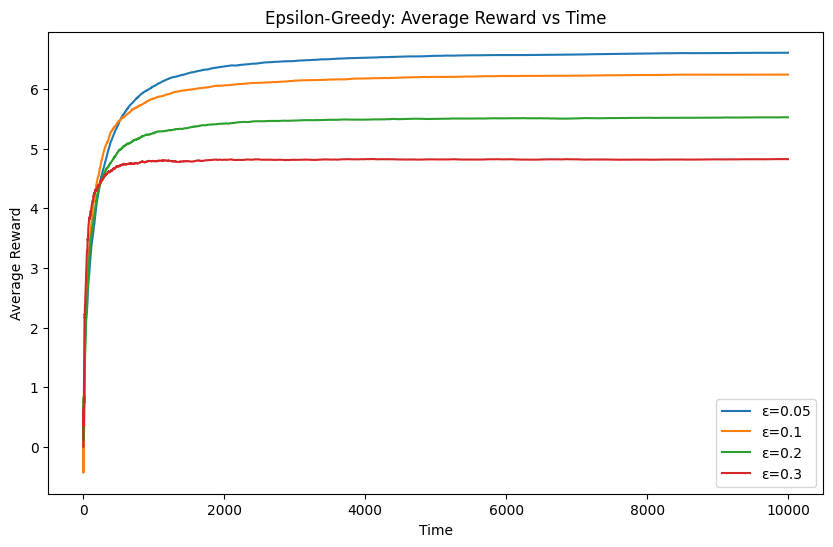

In [133]:
plt.figure(figsize=(10,6))
for e in epsilons:
    plt.plot(eg_results[e]["mean"], label=f"ε={e}")
plt.xlabel("Time")
plt.ylabel("Average Reward")
plt.title("Epsilon-Greedy: Average Reward vs Time")
plt.legend()
plt.show()


/tmp/ipython-input-214162743.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


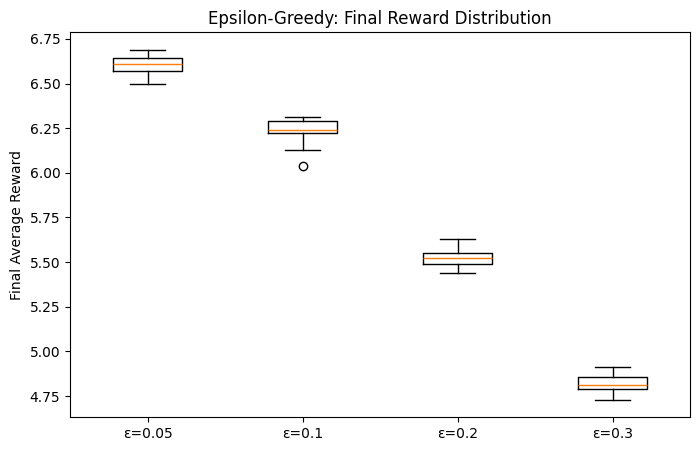

In [134]:
plt.figure(figsize=(8,5))
plt.boxplot(
    [eg_results[e]["final"] for e in epsilons],
    labels=[f"ε={e}" for e in epsilons]
)
plt.ylabel("Final Average Reward")
plt.title("Epsilon-Greedy: Final Reward Distribution")
plt.show()


In [135]:
best_epsilon = max(epsilons, key=lambda e: np.median(eg_results[e]["final"]))

category_rewards = {c: [] for c in range(4)}
for _ in range(RUNS):
    _, cat_r = epsilon_greedy(T, best_epsilon)
    for c in range(4):
        category_rewards[c].extend(cat_r[c])


/tmp/ipython-input-3236610875.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


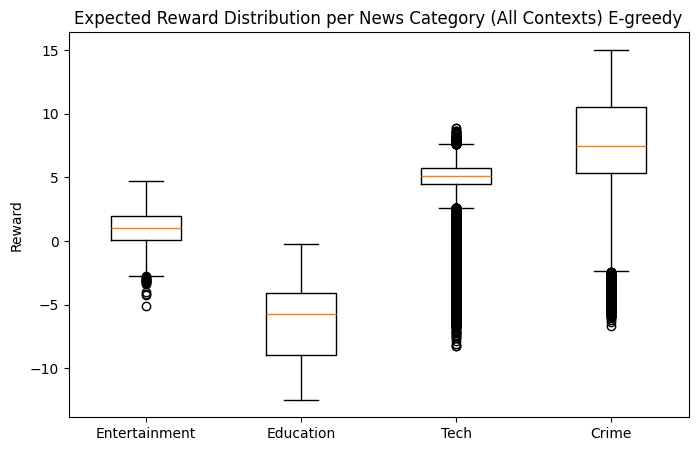

In [136]:
plt.figure(figsize=(8,5))
plt.boxplot(
    [category_rewards[c] for c in range(4)],
    labels=["Entertainment", "Education", "Tech", "Crime"]
)
plt.ylabel("Reward")
plt.title("Expected Reward Distribution per News Category (All Contexts) E-greedy")
plt.show()


## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

In [137]:
def ucb(T, C):
    Q = np.zeros((3, 4))
    N = np.ones((3, 4))

    avg_rewards = []
    category_rewards = {c: [] for c in range(4)}

    for t in range(1, T+1):
        context = np.random.randint(0, 3)
        ucb_values = Q[context] + C * np.sqrt(np.log(t) / N[context])
        category = np.argmax(ucb_values)

        arm = arm_index(context, category)
        reward = reward_sampler.sample(arm)

        N[context][category] += 1
        Q[context][category] += (reward - Q[context][category]) / N[context][category]

        avg_rewards.append(reward)
        category_rewards[category].append(reward)

    return np.cumsum(avg_rewards) / np.arange(1, T+1), category_rewards


In [138]:
Cs = [0.5, 1.0, 2.0]
ucb_results = {}

for c in Cs:
    runs = []
    finals = []

    for _ in range(RUNS):
        avg_r, _ = ucb(T, c)
        runs.append(avg_r)
        finals.append(avg_r[-1])

    ucb_results[c] = {
        "mean": np.mean(runs, axis=0),
        "std": np.std(runs, axis=0),
        "final": finals
    }


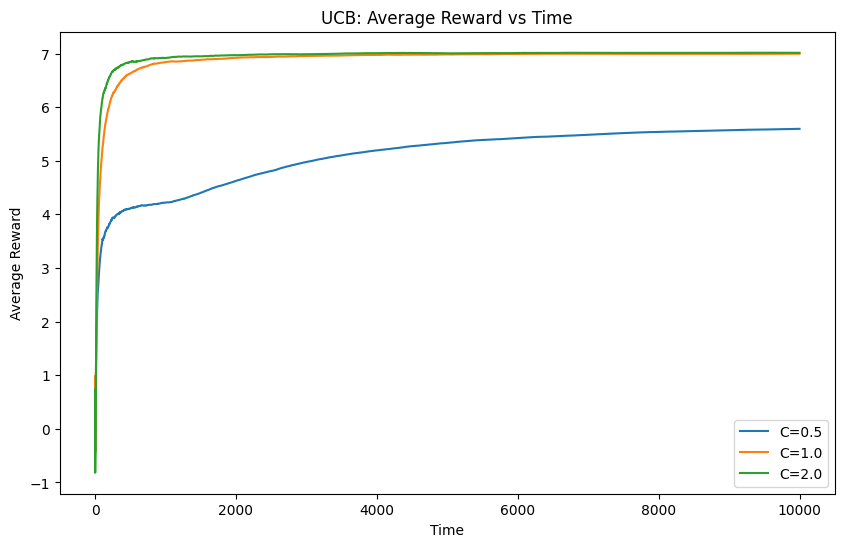

In [139]:
plt.figure(figsize=(10,6))
for c in Cs:
    plt.plot(ucb_results[c]["mean"], label=f"C={c}")
plt.xlabel("Time")
plt.ylabel("Average Reward")
plt.title("UCB: Average Reward vs Time")
plt.legend()
plt.show()


In [140]:
best_C = max(Cs, key=lambda c: np.median(ucb_results[c]["final"]))

ucb_cat_rewards = {c: [] for c in range(4)}
for _ in range(RUNS):
    _, cat_r = ucb(T, best_C)
    for c in range(4):
        ucb_cat_rewards[c].extend(cat_r[c])


/tmp/ipython-input-1568517665.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


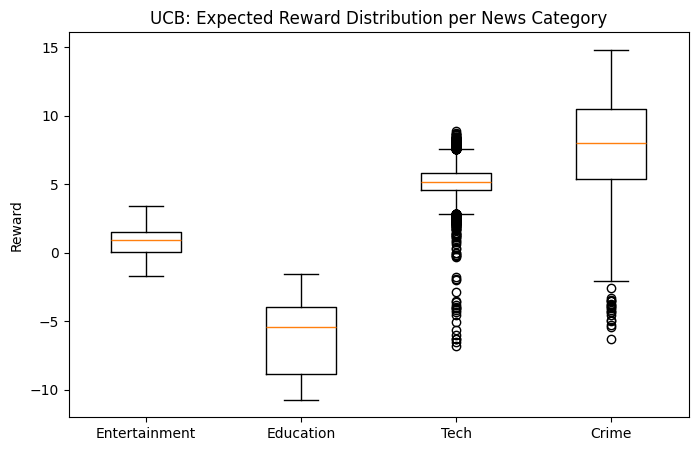

In [141]:
plt.figure(figsize=(8,5))
plt.boxplot(
    [ucb_cat_rewards[c] for c in range(4)],
    labels=["Entertainment", "Education", "Tech", "Crime"]
)
plt.ylabel("Reward")
plt.title("UCB: Expected Reward Distribution per News Category")
plt.show()


## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


In [142]:
def softmax(T, tau=1):
    Q = np.zeros((3, 4))
    N = np.ones((3, 4))

    avg_rewards = []
    category_rewards = {c: [] for c in range(4)}

    for t in range(T):
        context = np.random.randint(0, 3)
        probs = np.exp(Q[context] / tau)
        probs /= probs.sum()

        category = np.random.choice(4, p=probs)
        arm = arm_index(context, category)
        reward = reward_sampler.sample(arm)

        N[context][category] += 1
        Q[context][category] += (reward - Q[context][category]) / N[context][category]

        avg_rewards.append(reward)
        category_rewards[category].append(reward)

    return np.cumsum(avg_rewards) / np.arange(1, T+1), category_rewards


In [143]:
softmax_runs = []
for _ in range(RUNS):
    avg_r, _ = softmax(T)
    softmax_runs.append(avg_r)

softmax_runs = np.array(softmax_runs)


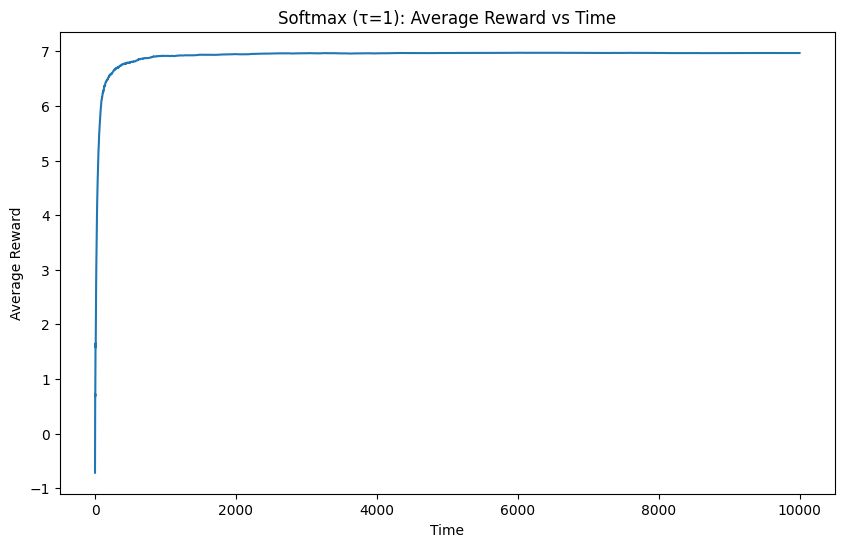

In [144]:
plt.figure(figsize=(10,6))
plt.plot(softmax_runs.mean(axis=0))
plt.xlabel("Time")
plt.ylabel("Average Reward")
plt.title("Softmax (τ=1): Average Reward vs Time")
plt.show()


In [145]:
softmax_cat_rewards = {c: [] for c in range(4)}
for _ in range(RUNS):
    _, cat_r = softmax(T)
    for c in range(4):
        softmax_cat_rewards[c].extend(cat_r[c])


/tmp/ipython-input-3432662825.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


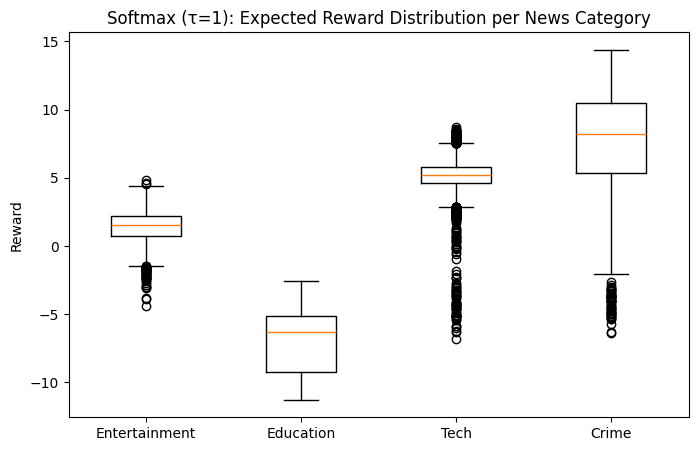

In [146]:
plt.figure(figsize=(8,5))
plt.boxplot(
    [softmax_cat_rewards[c] for c in range(4)],
    labels=["Entertainment", "Education", "Tech", "Crime"]
)
plt.ylabel("Reward")
plt.title("Softmax (τ=1): Expected Reward Distribution per News Category")
plt.show()


# 5.5 Recommender system

In [148]:
"""
Section 5.4: Recommendation Engine (Final)
Uses column: headline (no article_id)
"""

def compute_Q_values_from_softmax(n_contexts=3, n_categories=4, n_samples=100):
    Q_values = {}

    for context in range(n_contexts):
        Q_values[context] = np.zeros(n_categories)
        for category in range(n_categories):
            arm = context * n_categories + category
            rewards = [reward_sampler.sample(arm) for _ in range(n_samples)]
            Q_values[context][category] = np.mean(rewards)

    return Q_values


print("Computing Q-values for recommendation system...")
Q_values_by_context = compute_Q_values_from_softmax()

news_categories = ['Entertainment', 'Education', 'Tech', 'Crime']
user_labels = ['user_3', 'user_2', 'user_1']

print("\nComputed Q-values:")
for context in range(3):
    print(f"\nContext {context} ({user_labels[context]}):")
    for i, cat in enumerate(news_categories):
        print(f"  {cat:15s}: {Q_values_by_context[context][i]:7.4f}")


def softmax_action(Q, tau=0.1):
    Q = np.asarray(Q)
    probs = np.exp(Q / tau)
    probs /= probs.sum()
    return np.random.choice(len(Q), p=probs)


def recommend_article(context, Q_softmax, news_df, tau=0.1):
    action_idx = softmax_action(Q_softmax, tau)
    category = news_categories[action_idx]

    candidates = news_df[news_df["category"] == category]
    article = candidates.sample(1).iloc[0] if len(candidates) else news_df.sample(1).iloc[0]

    return {
        "context": int(context),
        "user_type": user_labels[int(context)],
        "recommended_category": category,
        "headline": article["headline"],
        "short_description": article["short_description"],
        "link": article["link"],
        "date": article["date"],
    }


contexts = xgb_model.predict(test_users_proc)
recommendations = []

print("\n" + "=" * 70)
print(f"Generating recommendations for {len(contexts)} test users...")
print("=" * 70)
print(f"Context distribution: {np.bincount(contexts)}")

for i, context in enumerate(contexts):
    Q = Q_values_by_context[int(context)]
    recommendations.append(recommend_article(context, Q, news_df, tau=1.0))

    if (i + 1) % 500 == 0:
        print(f"  Generated {i + 1}/{len(contexts)} recommendations...")

print(f"  Completed all {len(contexts)} recommendations!\n")

recommendations_df = pd.DataFrame(recommendations)

print("=" * 70)
print("RECOMMENDATION SYSTEM RESULTS")
print("=" * 70)

print("\nSample Recommendations:")
print(recommendations_df[['context', 'user_type', 'recommended_category', 'headline']].head(15))

print("\n" + "=" * 70)
print(f"Total Recommendations Generated: {len(recommendations_df)}")
print("=" * 70)

print("\n" + "-" * 70)
print("Recommendation Distribution by Category:")
print("-" * 70)
for cat, count in recommendations_df['recommended_category'].value_counts().items():
    pct = 100 * count / len(recommendations_df)
    print(f"{cat:15s}: {count:5d} ({pct:5.2f}%) {'█' * int(pct / 2)}")

print("\n" + "-" * 70)
print("Recommendation Distribution by User Type:")
print("-" * 70)
for user, count in recommendations_df['user_type'].value_counts().items():
    pct = 100 * count / len(recommendations_df)
    print(f"{user:15s}: {count:5d} ({pct:5.2f}%) {'█' * int(pct / 2)}")

print("\n" + "=" * 70)
print("Sample Recommendations by User Type:")
print("=" * 70)
for user_type in user_labels:
    subset = recommendations_df[recommendations_df['user_type'] == user_type]
    if subset.empty:
        continue

    print(f"\n{user_type.upper()} ({len(subset)} total):")
    for _, row in subset.head(5).iterrows():
        headline = row['headline']
        headline = headline[:65] + "..." if len(headline) > 65 else headline
        print(f"  • {row['recommended_category']:15s} | {headline}")

print("\n" + "=" * 70)
print("Category Preferences by User Type:")
print("=" * 70)
for user_type in user_labels:
    subset = recommendations_df[recommendations_df['user_type'] == user_type]
    if subset.empty:
        continue

    print(f"\n{user_type.upper()}:")
    for cat, count in subset['recommended_category'].value_counts().items():
        pct = 100 * count / len(subset)
        print(f"  {cat:15s}: {count:5d} ({pct:5.2f}%)")


Computing Q-values for recommendation system...

Computed Q-values:

Context 0 (user_3):
  Entertainment  :  0.1611
  Education      : -9.4493
  Tech           :  5.2024
  Crime          : -3.9531

Context 1 (user_2):
  Entertainment  :  1.7926
  Education      : -5.6513
  Tech           : -4.3751
  Crime          :  5.3778

Context 2 (user_1):
  Entertainment  :  0.3827
  Education      : -3.5889
  Tech           :  1.5566
  Crime          : 10.6708

Generating recommendations for 2000 test users...
Context distribution: [672 704 624]
  Generated 500/2000 recommendations...
  Generated 1000/2000 recommendations...
  Generated 1500/2000 recommendations...
  Generated 2000/2000 recommendations...
  ✓ Completed all 2000 recommendations!

RECOMMENDATION SYSTEM RESULTS

Sample Recommendations:
    context user_type recommended_category  \
0         1    user_2                Crime   
1         0    user_3                 Tech   
2         0    user_3                 Tech   
3         0    